This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/optimization.html).  I recommend having both windows open, side-by-side!


In [2]:
import sys
sys.path.append('/opt/drake/lib/python3.8/site-packages/')
sys.path.append('/home/aditya/Documents/projects/manipulation/')
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from pydrake.all import MathematicalProgram, Solve


# SDP relaxation of non-convex quadratic constraints

Consider the problem:

\begin{align*}
\min_x \quad & \| x - a \|^2 \\
\text{subject to} \quad & \| x - b \| \ge 1
\end{align*}

We can write this as

\begin{align*}
\min_{x,y} \quad & y - 2ax + a^2 \\
\text{subject to} \quad & y - 2bx + b^2 \ge 1 \\
& y \ge x^2
\end{align*}

where we write $y \ge x^2$ as the semidefinite constraint
$\begin{bmatrix} y & x \\ x & 1 \end{bmatrix}.$  I've plotted the feasible
region and the objective with an arrow.  As you know, for linear
objectives, the optimal solution will lie on the boundary only if the cost is
directly orthogonal to the objective; otherwise it will lie at a vertex.  So in
this case, the solution will only lie on the interior if $a = b;$ for every
other value, this relaxation will give the optimal solution.  (Try changing $a$ to see).

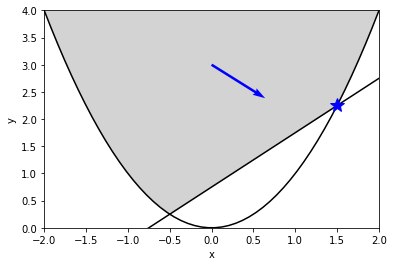

None

In [4]:
def sdf_nonconvex_quadratic():
    fig, ax = plt.subplots()
    a = .8
    b = .5
    x = np.linspace(-2, 2)
    plt.fill(x, np.maximum(x*x, 1 + 2*b*x - b*b), color='lightgray')
    ax.plot(x, x*x, 'k')
    ax.plot(x, 1 + 2*b*x - b*b, 'k')
    qx = 0
    qy = 3
    scale=4
    ax.quiver(qx, qy, 2*a, -1, scale=10, zorder=2, color='b')

    ax.set_xlim(-2, 2)
    ax.set_ylim(0, 4)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    prog = MathematicalProgram()
    x = prog.NewContinuousVariables(1, 'x')[0]
    y = prog.NewContinuousVariables(1, 'y')[0]

    prog.AddPositiveSemidefiniteConstraint(np.array([[y, x],[x, 1]]))
    prog.AddLinearConstraint(y - 2*b*x + b*b >= 1)
    prog.AddLinearCost(y - 2*a*x + a*a)

    result = Solve(prog)
    ax.plot(result.GetSolution(x), result.GetSolution(y), 'b*', markersize=15)
    display(plt.show())

sdf_nonconvex_quadratic()

# Global optimization with Sums-of-Squares (the "Six Hump Camel")

Minimum value (lower bound): -1.0316284603954207
Minimum sampled value: -1.031155541224238


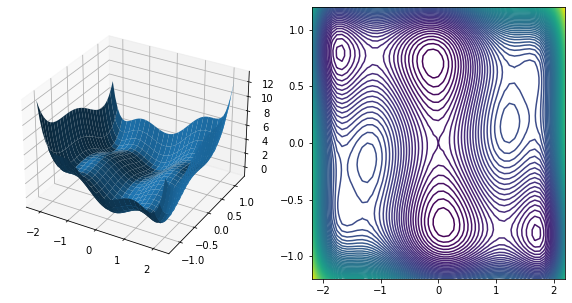

None

In [5]:
def sos_six_hump_camel():
    prog = MathematicalProgram()
    v = prog.NewIndeterminates(2, "x")
    x = v[0]
    y = v[1]

    # This is the famous "six-hump camel back function".  It has six local
    # minima, two of them being global minima.
    p = 4 * x**2 + x * y - 4 * y**2 - 2.1 * x**4 + 4 * y**4 + x**6 / 3

    # Find the minimum value by adding a sums of squares constraint, via
    #   for all x, p(x) >= pmin
    # which we write as
    #   p(x) - pmin is sos.
    pmin = prog.NewContinuousVariables(1, "pmin")[0]
    prog.AddSosConstraint(p - pmin)

    # Maximize pmin.
    prog.AddCost(-pmin)

    result = Solve(prog)
    assert result.is_success()
    print("Minimum value (lower bound): " + str(result.GetSolution(pmin)))

    # Now, let's plot it.
    fig = plt.figure(figsize=(10, 5))
    ax0 = fig.add_subplot(121, projection="3d")
    ax1 = fig.add_subplot(122)
    xs = np.linspace(-2.2, 2.2, 51)
    ys = np.linspace(-1.2, 1.2, 51)
    [X, Y] = np.meshgrid(xs, ys)
    P = X.copy()
    for i in range(len(xs)):
        for j in range(len(ys)):
            P[i, j] = p.Evaluate({x: X[i, j], y: Y[i, j]})
    ax0.plot_surface(X, Y, P)
    ax1.contour(X, Y, P, 100)

    print("Minimum sampled value: " + str(np.min(P)))
    display(plt.show())

sos_six_hump_camel()